In [110]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn

In [111]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Dropout,LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

In [112]:
data = pd.read_csv('data/poluicao.csv')
data

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43819,43820,2014,12,31,19,8.0,-23,-2.0,1034.0,NW,231.97,0,0
43820,43821,2014,12,31,20,10.0,-22,-3.0,1034.0,NW,237.78,0,0
43821,43822,2014,12,31,21,10.0,-22,-3.0,1034.0,NW,242.70,0,0
43822,43823,2014,12,31,22,8.0,-22,-4.0,1034.0,NW,246.72,0,0


In [113]:
data = data.drop(columns=['No', 'year', 'month', 'day', 'hour', 'cbwd'], axis=1)
data = data.dropna()

In [114]:
data

,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir
24,129.0,-16,-4.0,1020.0,1.79,0,0
25,148.0,-15,-4.0,1020.0,2.68,0,0
26,159.0,-11,-5.0,1021.0,3.57,0,0
27,181.0,-7,-5.0,1022.0,5.36,1,0
28,138.0,-7,-5.0,1022.0,6.25,2,0
...,...,...,...,...,...,...,...
43819,8.0,-23,-2.0,1034.0,231.97,0,0
43820,10.0,-22,-3.0,1034.0,237.78,0,0
43821,10.0,-22,-3.0,1034.0,242.70,0,0
43822,8.0,-22,-4.0,1034.0,246.72,0,0


In [115]:
train_data = data.iloc[:, 1:7].values

In [116]:
test_data = data.iloc[:, 0].values

In [117]:
scale = MinMaxScaler(feature_range=(0,1))
train_data_scaled = scale.fit_transform(train_data)

In [118]:
test_data = test_data.reshape(-1,1)
scaled_test_data = scale.fit_transform(test_data)


In [119]:
X = [] # previsores
y = [] # poluição real
for i in range(90, 1242): # 90 preços anteriores
    X.append(train_data_scaled[i-10:i, 0:6])
    y.append(train_data_scaled[i, 0])
X, y = np.array(X), np.array(y)

In [120]:
model = Sequential()

model.add(LSTM(units=100, return_sequences=True, input_shape=(X.shape[1], 6)))
model.add(Dropout(0.3))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.3))

model.add(LSTM(units=50))
model.add(Dropout(0.3))

model.add(Dense(units=1, activation='linear'))

model.summary()

c:\Users\wilso\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_24 (LSTM)                  │ (None, 10, 100)        │        42,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 10, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_25 (LSTM)                  │ (None, 10, 50)         │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 10, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_26 (LSTM)                  │ (None, 10, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 10, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_27 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 113,451 (443.17 KB)

 Trainable params: 113,451 (443.17 KB)

 Non-trainable params: 0 (0.00 B)

In [121]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

In [122]:
es = EarlyStopping(monitor='loss', min_delta=1e-10, patience=10, verbose=True)
rlr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=5, verbose=1)
mcp = ModelCheckpoint(filepath='data/pesos.keras', monitor='loss', save_best_only=True, verbose=1)

In [128]:
model.fit(X, y, epochs=100, batch_size=64)

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0027 - mean_absolute_error: 0.0410
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0031 - mean_absolute_error: 0.0422
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0030 - mean_absolute_error: 0.0434
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0032 - mean_absolute_error: 0.0441
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0031 - mean_absolute_error: 0.0438
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0030 - mean_absolute_error: 0.0433
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0034 - mean_absolute_error: 0.0453
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0030 - mean_absolute_error: 0.0417
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0031 - mean_absolute_error: 0.0426
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0033 - mean_absolute_error: 0.0439
Epoch 11/100
18/18 ━━━━━━━━━━

In [129]:
predictors = model.predict(X)
predictors = scale.inverse_transform(predictors)

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


In [130]:
predictors.mean()

355.78903

In [131]:
test_data.mean()

98.61321455085375

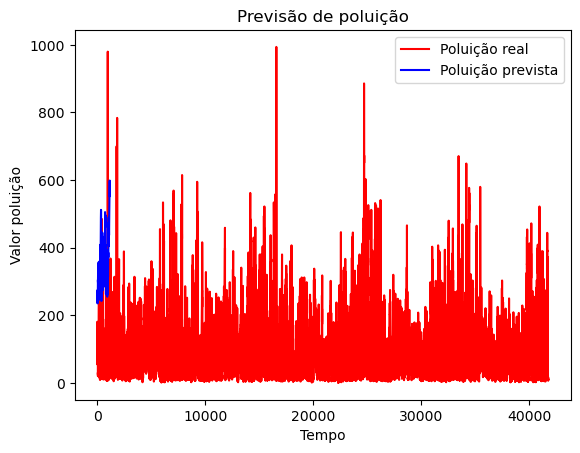

In [139]:
plt.plot(test_data, color='red', label='Poluição real')
plt.plot(predictors, color='blue', label='Poluição prevista')
plt.title('Previsão de poluição')
plt.xlabel('Tempo')
plt.ylabel('Valor poluição')
plt.legend()
plt.show()